In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mapsplotlib import mapsplot as mplt
import folium
from gmplot import gmplot
import branca
import seaborn as sns
# import plotly.plotly as py
# import plotly.graph_objs as go

%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

# load data

In [2]:
sales_granular = pd.read_csv('data/sales_granular.csv')

surrounding = pd.read_json('data/Surroundings.json')

In [3]:
print("sales_granular.csv")
print("Number of shops", len(sales_granular))
assert sales_granular.columns[0] == 'store_code'
dates = sales_granular.columns[1:]
print("Data from", dates[0], "to", dates[-1])
print()

print("surrounding.json")
print(surrounding.keys())
print("Number of shops", len(surrounding))

sales_granular.csv
Number of shops 906
Data from 8/3/15 9:00 to 6/25/17 22:00

surrounding.json
Index(['store_code', 'surroundings'], dtype='object')
Number of shops 546


In [4]:
# merge to focus only on the stores where we have both sales and info on surroundings
store = pd.merge(sales_granular, surrounding, how='inner', on='store_code')
len(store)

546

# lets define our target variable

In [5]:
# performance will be define as the total of sales
# calculate total for each POS
# on all data, per day of week, monthly, annualy
# having the target not only on the all period can help to detect different features
# notes: day of year too sparse, day of month too

index_time = store[dates].T  # transpose to have timestamp on index -> easier
dt = pd.to_datetime(index_time.index)

total = index_time.sum()
total_dayofweek = index_time.groupby(dt.dayofweek).sum()
total_month = index_time.groupby(dt.month).sum()
total_year = index_time.groupby(dt.year).sum()
total_hour = index_time.groupby(dt.hour).sum()

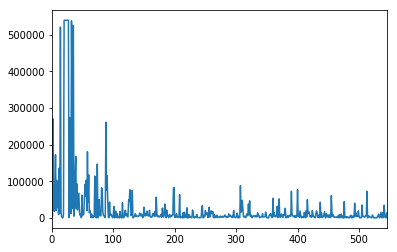

In [6]:
total.plot()

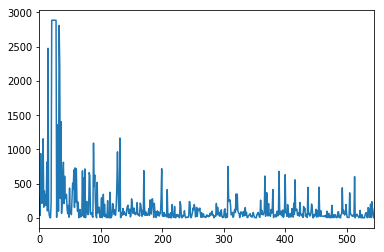

In [7]:
index_time.count().plot()

the correlation between total of sells and number of day worked is pretty high

ideally the position of a POS should be decided by the interest of the area

0     44
1     40
2     46
3     35
4     30
5     48
6    281
dtype: int64


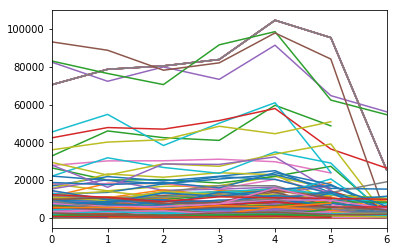

In [8]:
print(total_dayofweek.T.isnull().sum())
total_dayofweek.plot(legend=False)

1      93
2      62
3      59
4      54
5      52
6      45
7     453
8     443
9     438
10    437
11    248
12    138
dtype: int64


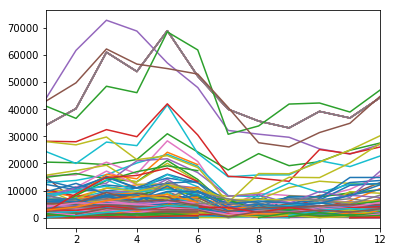

In [9]:
print(total_month.T.isnull().sum())
total_month.plot(legend=False)

2015    538
2016    123
2017      0
dtype: int64


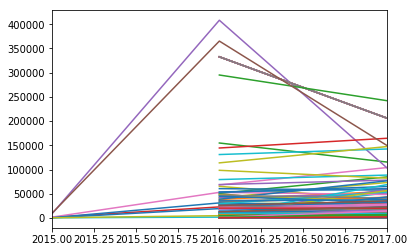

In [10]:
print(total_year.T.isnull().sum())
total_year.plot(legend=False)

0     546
1     546
2     546
3     546
4     546
5     497
6     334
7     210
8     121
9      93
10     81
11     80
12     76
13     77
14     73
15     67
16     59
17     64
18    116
19    339
20    442
21    481
22    521
23    532
dtype: int64


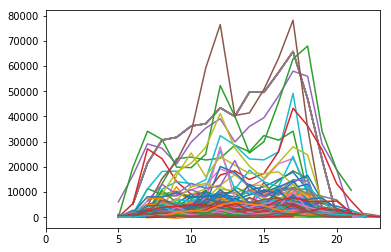

In [11]:
print(total_hour.T.isnull().sum())
total_hour.plot(legend=False)

the thing is that it seems that some place opened after others as some years have no income

some are also more likely to be close during summer vacation or sundays

to not have this biasing our result we can normalise per the days were something have been written

aka no nan

we will see later how that affect our analysis

the thing is that maybe some area cannot work on sundays but others can? that can modify the analysis

but i dont know enough about suisse custom and law to go further on this



In [12]:
total_norm = total / index_time.count()
total_dayofweek_norm = total_dayofweek / index_time.groupby(dt.dayofweek).count()
total_month_norm = total_month / index_time.groupby(dt.month).count()
total_year_norm = total_year / index_time.groupby(dt.year).count()
total_hour_norm = total_hour / index_time.groupby(dt.hour).count()

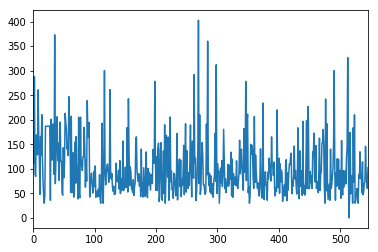

In [13]:
total_norm.plot()

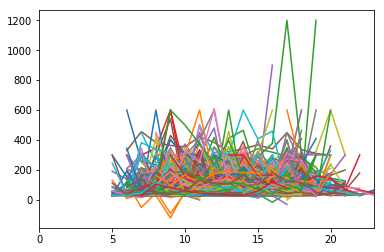

In [14]:
total_hour_norm.plot(legend=False)

this look more balanced, hence the number of days doesnt matter

we can focus now on area related features

note: we need to keep in mind that this consider that the number of days worked doesnt matter

In [15]:
target_dict = {'total': total.T,
               'total_dayofweek': total_dayofweek.T,
               'total_month': total_month.T,
               'total_year': total_year.T,
               'total_norm': total_norm.T,
               'total_dayofweek_norm': total_dayofweek_norm.T,
               'total_month_norm': total_month_norm.T,
               'total_year_norm': total_year_norm.T}

In [16]:
targets = pd.concat(target_dict, 1)
targets.head()
len(targets)

546

# lets dig inside the data about the surrounding

In [17]:
surrounding.head()

store_code                                       surroundings
0       10055  {'subway_station': [], 'department_store': [],...
1       10077  {'subway_station': [], 'department_store': [],...
2       10079  {'subway_station': [], 'department_store': [{'...
3       10086  {'subway_station': [], 'department_store': [],...
4       10111  {'subway_station': [], 'department_store': [],...

In [18]:
# lets check a bit more what is in the surroundings column
surr = store.surroundings.apply(pd.Series)
surr.head()

accounting airport amusement_park  \
0  [{'name': 'Fiduciaire Exacte & Gestion Comptab...      []             []   
1                                                 []      []             []   
2  [{'website': 'http://www.vd.ch/autorites/depar...      []             []   
3                                                 []      []             []   
4                                                 []      []             []   

  aquarium                                        art_gallery  \
0       []  [{'website': 'http://www.onegeeinfog.com/', 'n...   
1       []                                                 []   
2       []                                                 []   
3       []                                                 []   
4       []                                                 []   

                                                 atm  \
0  [{'website': 'https://www.ubs.com/ch/fr.html',...   
1                                                 []   
2  [{'name': 'PickPost-Stelle', 'opening_hours': ...   
3                                                 []   
4                                                 []   

                                              bakery  \
0  [{'name': 'Mconseils SA', 'place_id': 'ChIJRz1...   
1  [{'rating': 4.8, 'place_id': 'ChIJM8FbQe9vjEcR...   
2  [{'website': 'https://filialen.migros.ch/de/ta...   
3                                                 []   
4                                                 []   

                                                bank  \
0  [{'website': 'http://www.ubs.ch/', 'rating': 5...   
1                                                 []   
2  [{'website': 'https://www.ubs.com/ch/fr.html',...   
3                                                 []   
4                                                 []   

                                                 bar  \
0  [{'rating': 3.5, 'place_id': 'ChIJ8xHdm_1vjEcR...   
1                                                 []   
2  [{'website': 'https://www.facebook.com/Highlan...   
3  [{'website': 'http://www.oubangui.com/', 'rati...   
4                                                 []   

                                        beauty_salon ...  \
0  [{'website': 'http://www.jadebeaute.com/', 'ra... ...   
1                                                 [] ...   
2  [{'rating': 5, 'place_id': 'ChIJmxg6U4LPjUcR86... ...   
3  [{'website': 'http://www.blattnerpodologue.ch/... ...   
4                                                 [] ...   

                                               store subway_station synagogue  \
0  [{'website': 'https://filialen.migros.ch/de/mi...             []        []   
1  [{'website': 'http://www.coop.ch/fr/services/a...             []        []   
2  [{'website': 'http://www.denner.ch/', 'rating'...             []        []   
3  [{'rating': 3.3, 'place_id': 'ChIJUW-HLeAxjEcR...             []        []   
4  [{'name': 'lookemontre.com', 'opening_hours': ...             []        []   

  taxi_stand train_station                                    transit_station  \
0         []            []  [{'name': 'Chêne-Bourg, La Mousse', 'place_id'...   
1         []            []  [{'name': 'Chêne-Bougeries, Montagne', 'place_...   
2         []            []  [{'name': 'Yverdon-les-Bains, Bel-Air', 'place...   
3         []            []  [{'name': 'Bois-Gentil', 'place_id': 'ChIJK8fw...   
4         []            []  [{'name': 'Yverdon-les-Bains, Plaisance', 'pla...   

                                       travel_agency university  \
0  [{'name': 'Courir au Népal Sàrl', 'place_id': ...         []   
1                                                 []         []   
2  [{'website': 'http://www.hotelplan.ch/FR/', 'r...         []   
3                                                 []         []   
4                                                 []         []   

                                     veterinary_care zoo  
0  [{'website': 'http://www.vet

a very nested structure apparently

we need to know what we can get

### lets first count how many of each time are present for each shops

In [19]:
number_ameneties = surr.applymap(len)
number_ameneties.head()

accounting  airport  amusement_park  aquarium  art_gallery  atm  bakery  \
0           3        0               0         0            1    1       3   
1           0        0               0         0            0    0       1   
2           1        0               0         0            0    3       3   
3           0        0               0         0            0    0       0   
4           0        0               0         0            0    0       0   

   bank  bar  beauty_salon ...   store  subway_station  synagogue  taxi_stand  \
0     3    1             4 ...      31               0          0           0   
1     0    0             0 ...       6               0          0           0   
2     1    4             4 ...      53               0          0           0   
3     0    1             2 ...       3               0          0           0   
4     0    0             0 ...       2               0          0           0   

   train_station  transit_station  travel_agency  university  veterinary_care  \
0              0                2              1           0                1   
1              0                1              0           0                0   
2              0                4              2           0                0   
3              0                1              0           0                0   
4              0                4              0           0                0   

   zoo  
0    0  
1    0  
2    0  
3    0  
4    0  

[5 rows x 89 columns]

### now lets see what we have for each

In [20]:
surr_sets = surr.applymap(lambda x: [set(y.keys()) for y in x] if x else None)
surr_sets_inter = surr_sets.applymap(lambda x: set.intersection(*x) if x else set())
surr_sets_inter.head()

accounting airport amusement_park  \
0  {name, international_phone_number, latitude, f...      {}             {}   
1                                                 {}      {}             {}   
2  {name, international_phone_number, latitude, f...      {}             {}   
3                                                 {}      {}             {}   
4                                                 {}      {}             {}   

  aquarium                                        art_gallery  \
0       {}  {name, latitude, formatted_address, address_co...   
1       {}                                                 {}   
2       {}                                                 {}   
3       {}                                                 {}   
4       {}                                                 {}   

                                                 atm  \
0  {name, reviews, rating, international_phone_nu...   
1                                                 {}   
2  {name, international_phone_number, latitude, f...   
3                                                 {}   
4                                                 {}   

                                              bakery  \
0  {name, latitude, formatted_address, address_co...   
1  {name, reviews, rating, international_phone_nu...   
2  {name, international_phone_number, latitude, f...   
3                                                 {}   
4                                                 {}   

                                                bank  \
0  {name, reviews, rating, latitude, formatted_ad...   
1                                                 {}   
2  {name, reviews, rating, international_phone_nu...   
3                                                 {}   
4                                                 {}   

                                                 bar  \
0  {name, reviews, rating, international_phone_nu...   
1                                                 {}   
2  {name, reviews, international_phone_number, ra...   
3  {name, reviews, rating, international_phone_nu...   
4                                                 {}   

                                        beauty_salon ...  \
0  {name, international_phone_number, latitude, f... ...   
1                                                 {} ...   
2  {name, latitude, formatted_address, address_co... ...   
3  {website, name, reviews, international_phone_n... ...   
4                                                 {} ...   

                                               store subway_station synagogue  \
0  {name, latitude, formatted_address, address_co...             {}        {}   
1  {name, latitude, formatted_address, address_co...             {}        {}   
2  {name, latitude, formatted_address, address_co...             {}        {}   
3  {name, reviews, international_phone_number, la...             {}        {}   
4  {name, international_phone_number, latitude, f...             {}        {}   

  taxi_stand train_station                                    transit_station  \
0         {}            {}  {name, latitude, formatted_address, address_co...   
1         {}            {}  {name, latitude, formatted_address, address_co...   
2         {}            {}  {name, latitude, formatted_address, address_co...   
3         {}            {}  {name, latitude, formatted_address, address_co...   
4         {}            {}  {name, latitude, formatted_address, address_co...   

                                       travel_agency university  \
0  {name, latitude, formatted_address, address_co...         {}   
1                                                 {}         {}   
2  {name, international_phone_number, latitude, f...         {}   
3                                                 {}         {}   
4                                                 {}         {}   

                                     veterinary_care zoo  
0  {name, reviews, rating, inte

In [21]:
t = surr_sets_inter.apply(lambda x: set.union(*x))
t.head()

accounting        {name, reviews, international_phone_number, fo...
airport           {name, reviews, international_phone_number, fo...
amusement_park    {name, reviews, international_phone_number, fo...
aquarium          {name, reviews, international_phone_number, la...
art_gallery       {name, reviews, international_phone_number, fo...
dtype: object

In [22]:
inter = set.intersection(*[o for o in t if o])
union = set.union(*[o for o in t if o])
print(sorted(inter), len(inter))
print(sorted(union), len(union))
print(sorted(union-inter), len(union-inter))

['address_components', 'formatted_address', 'icon', 'latitude', 'longitude', 'name', 'place_id', 'reviews', 'types', 'user_ratings_total'] 10
['address_components', 'formatted_address', 'icon', 'international_phone_number', 'latitude', 'longitude', 'name', 'opening_hours', 'place_id', 'price_level', 'rating', 'reviews', 'types', 'user_ratings_total', 'website'] 15
['international_phone_number', 'opening_hours', 'price_level', 'rating', 'website'] 5


all place have 

'address_components', 'formatted_address', 'icon', 'latitude', 'longitude', 'name', 'place_id', 'reviews', 'types', 'user_ratings_total'

some have

'international_phone_number', 'opening_hours', 'price_level', 'rating', 'website'

What would be useful?

phone number and website are unlikely to help

lets watch for one ->

In [23]:
elemt = surr.accounting[0][0]
keys = sorted(elemt.keys())
# print(elemt)
for k in keys:
    print(k)
    print("->", elemt[k])

address_components
-> [{'long_name': '6', 'types': ['street_number'], 'short_name': '6'}, {'long_name': 'Rue de Genève', 'types': ['route'], 'short_name': 'Rue de Genève'}, {'long_name': 'Chêne-Bourg', 'types': ['locality', 'political'], 'short_name': 'Chêne-Bourg'}, {'long_name': 'Genève', 'types': ['administrative_area_level_2', 'political'], 'short_name': 'Genève'}, {'long_name': 'Genève', 'types': ['administrative_area_level_1', 'political'], 'short_name': 'GE'}, {'long_name': 'Switzerland', 'types': ['country', 'political'], 'short_name': 'CH'}, {'long_name': '1225', 'types': ['postal_code'], 'short_name': '1225'}]
formatted_address
-> Rue de Genève 6, 1225 Chêne-Bourg, Switzerland
icon
-> https://maps.gstatic.com/mapfiles/place_api/icons/generic_business-71.png
international_phone_number
-> +41 22 348 55 28
latitude
-> 46.195035
longitude
-> 6.192834800000001
name
-> Fiduciaire Exacte & Gestion Comptable Isotton Turel Sàrl
opening_hours
-> {'weekday_text': ['Monday: 9:00 AM – 5:0

In [24]:
amusement_park = surr.amusement_park
elemt = amusement_park[14][0]
keys = sorted(elemt.keys())
# print(elemt)
for k in keys:
    print(k)
    print("->", elemt[k])

address_components
-> [{'long_name': '14', 'types': ['street_number'], 'short_name': '14'}, {'long_name': 'Rue Edmond de Reynier', 'types': ['route'], 'short_name': 'Rue Edmond de Reynier'}, {'long_name': 'Neuchâtel', 'types': ['locality', 'political'], 'short_name': 'Neuchâtel'}, {'long_name': 'Neuchâtel', 'types': ['administrative_area_level_2', 'political'], 'short_name': 'Neuchâtel'}, {'long_name': 'Neuchâtel', 'types': ['administrative_area_level_1', 'political'], 'short_name': 'NE'}, {'long_name': 'Switzerland', 'types': ['country', 'political'], 'short_name': 'CH'}, {'long_name': '2000', 'types': ['postal_code'], 'short_name': '2000'}]
formatted_address
-> Rue Edmond de Reynier 14, 2000 Neuchâtel, Switzerland
icon
-> https://maps.gstatic.com/mapfiles/place_api/icons/generic_business-71.png
latitude
-> 46.9964652
longitude
-> 6.938777200000001
name
-> Place de jeux Edmond-de-Reynier
place_id
-> ChIJL1kuexgKjkcRAZdGMRXVDU8
rating
-> 3
reviews
-> [{'rating': 3, 'author_name': 'Stép

we dont have info about the shop position but we have of its surrounding

by taking the mean of all the shop we can guess the position of the shop

lets take latitude and longitude

---

adresses are a bit difficult, but having the city could be interesting

---

icon, name, phone number are not interesting

---

opening_hours could be very usefull to correlate with per hour sells

--- 

place_id not interesting

---

types could be interesting to make a bag of words like features

### lets extract some of those features

In [25]:
def get_feature(row, feature=None):
    lat = []
#     lon = []
#     print(len(x))
    if len(row)>0:
        for x in row:
            if len(x) > 0:
                for elemt in x:
        #             print(elemt.keys())
                    if feature in elemt.keys():
                        lat.append(elemt[feature])
    #                 lon.append(elemt['longitude'])
        if len(lat) == 0:
            return []
    return lat

def make_get_feature(feature):
    return lambda row: get_feature(row, feature)


In [26]:
extract_rating_total = surr.apply(make_get_feature('user_ratings_total'), 1)
extract_reviews = surr.apply(make_get_feature('reviews'), 1)

extract_name = surr.apply(make_get_feature('name'), 1)
extract_types = surr.apply(make_get_feature('types'), 1)
# extract_name = surr.dropna()

extract_lat = surr.apply(make_get_feature('latitude'), 1)
# extract_lat = extract_lat.dropna()

extract_lon = surr.apply(make_get_feature('longitude'), 1)
# extract_lon = extract_lon.dropna()

assert len(extract_lat) == len(extract_lon)
# extract_name = extract_name.iloc[extract_lat.index]
assert len(extract_lat) == len(extract_lon) == len(extract_name) == len(extract_reviews)

### locations

In [27]:
mean_lat = extract_lat.apply(lambda x: np.mean(x) if x else None)
mean_lon = extract_lon.apply(lambda x: np.mean(x) if x else None)
min_lat = extract_lat.apply(lambda x: min(x) if x else None)
max_lat = extract_lat.apply(lambda x: max(x) if x else None)
min_lon = extract_lon.apply(lambda x: min(x) if x else None)
max_lon = extract_lon.apply(lambda x: max(x) if x else None)
dlat = max_lat - min_lat
dlon = max_lon - min_lon

In [28]:
def haversine_np(lon1, lat1, dlon, dlat):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, dlon, dlat = map(np.radians, [lon1, lat1, dlon, dlat])

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat1+dlat) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

In [29]:
m = folium.Map(
    location=[np.mean(mean_lat), np.mean(mean_lon)],
    zoom_start=8
)

for la, lo, dla, dlo in zip(mean_lat, mean_lon, dlat, dlon):
    if not np.isnan(la):
        d = haversine_np(lo, la, dlo, dla)
#         print(d)
        folium.features.Circle(
            radius=d*700, # 700 instead of 1000, seems to be enough for the aprox i made
            location=[la, lo],
    #         popup='The Waterfront',
            color='crimson',
            fill=False,
        ).add_to(m)

# just plot the shops for some
for i in  range(3):
    for la, lo, te in zip(extract_lat.iloc[i], extract_lon.iloc[i], extract_name.iloc[i]):
        folium.features.Circle(location=[la, lo], radius=1, color='blue',
            fill=False,).add_to(m)

m

I couldnt manage to find a library to show all shops while keeping it embeded in the notebook thus the idea to just find the mean position

We can see that the shops are present a little bit everywhere

this makes think that having a map with the density in suisse would be very helpful

## types

In [30]:
extract_types.iloc[0]

[['accounting', 'finance', 'point_of_interest', 'establishment'],
 ['accounting', 'finance', 'point_of_interest', 'establishment'],
 ['accounting', 'finance', 'point_of_interest', 'establishment'],
 ['art_gallery', 'point_of_interest', 'establishment'],
 ['bank', 'atm', 'finance', 'point_of_interest', 'establishment'],
 ['bakery', 'food', 'store', 'point_of_interest', 'establishment'],
 ['bakery', 'cafe', 'food', 'store', 'point_of_interest', 'establishment'],
 ['bakery', 'cafe', 'food', 'store', 'point_of_interest', 'establishment'],
 ['bank', 'finance', 'point_of_interest', 'establishment'],
 ['bank', 'atm', 'finance', 'point_of_interest', 'establishment'],
 ['bank', 'finance', 'point_of_interest', 'establishment'],
 ['restaurant', 'bar', 'food', 'point_of_interest', 'establishment'],
 ['beauty_salon', 'point_of_interest', 'establishment'],
 ['hair_care', 'beauty_salon', 'point_of_interest', 'establishment'],
 ['hair_care', 'beauty_salon', 'point_of_interest', 'establishment'],
 ['be

In [31]:
from collections import Counter

In [32]:
pd_counter = lambda l: Counter([str(i) for sublist in l for i in sublist] if l else None)

In [33]:
bow_types = extract_types.apply(pd_counter).apply(pd.Series)
bow_types = bow_types.fillna(0).applymap(int)
bow_types.head()

accounting  airport  amusement_park  aquarium  art_gallery  atm  bakery  \
0           3        0               0         0            1    2       8   
1           0        0               0         0            0    0       2   
2           2        0               0         0            0    4       8   
3           0        0               0         0            0    0       0   
4           0        0               0         0            0    0       0   

   bank  bar  beauty_salon ...   subpremise  subway_station  synagogue  \
0     4    2             6 ...            0               0          0   
1     0    0             0 ...            0               0          0   
2     2    6             7 ...            0               0          0   
3     0    3             4 ...            0               0          0   
4     0    0             0 ...            0               0          0   

   taxi_stand  train_station  transit_station  travel_agency  university  \
0           0              0                4              1           0   
1           0              0                2              0           0   
2           0              0                8              2           0   
3           0              0                2              0           0   
4           0              0                8              0           0   

   veterinary_care  zoo  
0                1    0  
1                0    0  
2                0    0  
3                0    0  
4                0    0  

[5 rows x 102 columns]

this look a bit like number_ameneties

In [34]:
bow_types.sum().sort_values()[::-1]

point_of_interest         84478
establishment             84478
store                     32968
health                    16957
food                      15215
restaurant                 9943
clothing_store             8257
doctor                     7185
hair_care                  5493
home_goods_store           4719
finance                    4712
beauty_salon               4208
real_estate_agency         4182
transit_station            3602
bar                        3333
bus_station                3164
cafe                       3060
dentist                    2712
electronics_store          2538
shoe_store                 2447
lawyer                     2193
jewelry_store              2105
furniture_store            2082
meal_takeaway              2052
bakery                     2042
bank                       2017
lodging                    1860
pharmacy                   1709
travel_agency              1588
grocery_or_supermarket     1557
                          ...  
plumber 

In [35]:
number_ameneties.sum().sum()

84478

- point_of_interest:         82085.0
- establishment:             82085.0

all ameneties have establishment  and point_of_interest so lets drop them


In [36]:
bow_types = bow_types.drop(['establishment', 'point_of_interest'], 1)

lets remove also the less present, we cant really rely on them

In [37]:
E = lambda x: x*(1-x)
std_types = bow_types.std()  # .sort_values()
to_remove = std_types < E(0.85) # at least 85% of case
to_remove[to_remove].index

Index(['airport', 'aquarium', 'casino', 'movie_rental', 'synagogue'], dtype='object')

In [38]:
bow_types = bow_types.drop(to_remove[to_remove].index, 1)
bow_types.head()

accounting  amusement_park  art_gallery  atm  bakery  bank  bar  \
0           3               0            1    2       8     4    2   
1           0               0            0    0       2     0    0   
2           2               0            0    4       8     2    6   
3           0               0            0    0       0     0    3   
4           0               0            0    0       0     0    0   

   beauty_salon  bicycle_store  book_store ...   store  subpremise  \
0             6              2           0 ...      64           0   
1             0              0           0 ...      10           0   
2             7              2           2 ...      94           0   
3             4              0           0 ...       4           0   
4             0              0           0 ...       4           0   

   subway_station  taxi_stand  train_station  transit_station  travel_agency  \
0               0           0              0                4              1   
1               0           0              0                2              0   
2               0           0              0                8              2   
3               0           0              0                2              0   
4               0           0              0                8              0   

   university  veterinary_care  zoo  
0           0                1    0  
1           0                0    0  
2           0                0    0  
3           0                0    0  
4           0                0    0  

[5 rows x 95 columns]

### lets do same for number ameneties

In [39]:
std_number_ameneties = number_ameneties.std()  # .sort_values()
to_remove = std_number_ameneties < E(0.85) # at least 85% of case
to_remove[to_remove].index

Index(['airport', 'amusement_park', 'aquarium', 'campground', 'casino',
       'hindu_temple', 'movie_rental', 'rv_park', 'synagogue', 'zoo'],
      dtype='object')

In [40]:
number_ameneties = number_ameneties.drop(to_remove[to_remove].index, 1)
number_ameneties.head()

accounting  art_gallery  atm  bakery  bank  bar  beauty_salon  \
0           3            1    1       3     3    1             4   
1           0            0    0       1     0    0             0   
2           1            0    3       3     1    4             4   
3           0            0    0       0     0    1             2   
4           0            0    0       0     0    0             0   

   bicycle_store  book_store  bowling_alley       ...         stadium  \
0              1           0              0       ...               0   
1              0           0              0       ...               0   
2              1           1              0       ...               0   
3              0           0              0       ...               0   
4              0           0              0       ...               0   

   storage  store  subway_station  taxi_stand  train_station  transit_station  \
0        1     31               0           0              0                2   
1        0      6               0           0              0                1   
2        0     53               0           0              0                4   
3        0      3               0           0              0                1   
4        0      2               0           0              0                4   

   travel_agency  university  veterinary_care  
0              1           0                1  
1              0           0                0  
2              2           0                0  
3              0           0                0  
4              0           0                0  

[5 rows x 79 columns]

### lets check the ratings

first how many

In [41]:
extract_number_reviews = extract_rating_total.apply(lambda x: Counter([i for i in x if i]) if x else None).apply(pd.Series).fillna(0).applymap(int)

In [42]:
extract_number_reviews.head()

1     2     3     4     5     6     7     8     9     10    ...   663   \
0    23    18     5     2     6     1     2     1     0     4  ...      0   
1     2     2     0     2     2     0     0     0     0     0  ...      0   
2    33    17     9     7     4     9     3     0     1     0  ...      0   
3     4     2     5     0     1     0     0     0     0     3  ...      0   
4     5     2     0     1     0     0     0     0     0     0  ...      0   

   682   702   1130  1131  1136  1357  1362  1363  1848  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0  

[5 rows x 286 columns]

the ratings range from 1 to 1848

In [43]:
extract_number_reviews.sum()

1       11617
2        6270
3        3926
4        2640
5        2143
6        1506
7        1221
8         946
9         827
10        628
11        598
12        514
13        506
14        468
15        389
16        322
17        350
18        283
19        335
20        245
21        256
22        230
23        199
24        216
25        182
26        194
27        165
28        180
29        185
30        119
        ...  
348         4
358         2
373         5
382         1
383         2
405         1
411         4
414         3
420         2
422         4
444         2
460         2
469         1
482         2
494         2
500         3
508         4
553         1
572         1
578         5
663         2
682         2
702         1
1130        1
1131        4
1136        2
1357        3
1362        1
1363        1
1848        1
dtype: int64

most only have 1 reviews which can make use wonder how certain they are

In [44]:
extract_reviews.head()

0    [[{'rating': 4, 'author_name': 'mar lmt', 'lan...
1    [[{'rating': 4, 'author_name': 'Marc Streiff',...
2    [[{'rating': 4, 'author_name': 'Fatoch Libon',...
3    [[{'rating': 5, 'author_name': 'Tony Maillard'...
4    [[{'rating': 3, 'author_name': 'Ervin Sheu', '...
dtype: object

In [45]:
extract_rating = extract_reviews.apply(make_get_feature('rating'))
extract_rating.head()

0    [4, 3, 3, 3, 4, 4, 5, 4, 4, 4, 5, 4, 5, 5, 5, ...
1    [4, 5, 5, 5, 5, 3, 5, 5, 5, 1, 5, 4, 4, 4, 5, ...
2    [4, 5, 4, 1, 5, 5, 4, 5, 5, 5, 4, 4, 4, 2, 4, ...
3    [5, 3, 4, 5, 3, 5, 5, 5, 5, 5, 3, 4, 5, 3, 1, ...
4    [3, 5, 5, 5, 4, 2, 4, 3, 4, 1, 5, 4, 5, 4, 4, ...
dtype: object

In [46]:
# lets keep it simple and just take the rating of the area by taking the mean
mean_rating = extract_rating.apply((lambda x: np.mean(x) if x else None))
mean_rating.head()

0    4.282700
1    4.241379
2    4.057229
3    4.094340
4    3.750000
dtype: float64

## Let's get an idea of how our feature look depending of the position

In [47]:
def normalize(x):
    a = x - x.min()
    return (a/a.max())

In [48]:
dist = haversine_np(mean_lon, mean_lat, dlon, dlat) * 700

In [49]:
def plt_map(mean_lat, mean_lon, dist, feature):
    cm = branca.colormap.LinearColormap(['green', 'yellow', 'red'], vmin=0, vmax=1)
    n = normalize(feature)
    color = [cm(x) if not np.isnan(x) else None for x in n]

    m = folium.Map(
        location=[np.mean(mean_lat), np.mean(mean_lon)],
        zoom_start=8
    )

    for la, lo, d, c in zip(mean_lat, mean_lon, dist, color):
        if not np.isnan(la):
#             d = haversine_np(lo, la, dlo, dla)
            folium.features.Circle(
                radius=d,
                location=[la, lo],
                color=c,
                fill_color=c,
                fill_opacity=0.6,
                fill=True,
            ).add_to(m)

    return m

In [50]:
plt_map(mean_lat, mean_lon, dist, mean_rating)

In [51]:
plt_map(mean_lat, mean_lon, dist, extract_number_reviews.sum(1))

In [52]:
plt_map(mean_lat, mean_lon, dist, targets.total[0])

In [53]:
plt_map(mean_lat, mean_lon, dist, targets.total_norm[1])

In [54]:
# plt_map(mean_lat, mean_lon, dist, number_ameneties['accounting'])

Lots of things that we can guess from those maps:

- city dont make the most
- ratings are relevant only in city
- airport big plus near lausanne
-
-
-

## lets make a model

as we dont have so many data it might e necessary to do n cross validation

In [55]:
# feature = pd.concat({'latitude': mean_lat, 'longitude': mean_lon, 'rating': mean_rating, 'bow_types': bow_types, 'number_ameneties': number_ameneties})
# # feature = pd.concat([ feature, bow_types, number_ameneties])
# feature.columns

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.feature_selection import SelectKBest, chi2, f_regression

from sklearn.feature_selection import SelectKBest, chi2, f_regression

In [57]:
parameters_xgboost = {
              'learning_rate': [0.001, 0.01, 0.1], #so called `eta` value
              'max_depth': [3, 6, 8],
              'subsample': [0.6, 0.7, 0.8],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'n_estimators': [200], #number of trees, change it to 1000 for better results
              'seed': [1337]}

clf_xgboost = GridSearchCV(XGBRegressor(eval_metric='mae'), parameters_xgboost, n_jobs=2, 
                   cv=KFold(n_splits=5, shuffle=True),
#                    scoring='accuracy',
                   verbose=1,
                   refit=True)

In [58]:
X_train_id, X_test_id, y_train_id, y_test_id = train_test_split(
    range(len(bow_types)), range(len(bow_types)), test_size=0.20, random_state=42)

In [59]:
def train_printinfo(feature, target, clf=clf_xgboost):
    X_train = feature.iloc[X_train_id].as_matrix()
    y_train = target.iloc[y_train_id].as_matrix()
    X_test = feature.iloc[X_test_id].as_matrix()
    y_test = target.iloc[y_test_id].as_matrix()

    clf.fit(X_train, y_train)

    print('='*10)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    
    y_pred = clf.best_estimator_.predict(X_test)
    print("mae", np.mean(np.abs(y_pred - y_test)))
          
    print("clf score", clf.score(X_test, y_test))
        
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.show()

    try:
        importances = clf.best_estimator_.feature_importances_

        # plt.bar(range(len(bow_types.columns)), importances,
        #        color="r", align="center")
        imp = pd.Series(importances, index=feature.columns).sort_values()[::-1]
        imp.plot.bar()
        plt.show()

        print(imp[:20])
    except:
        pass
    
    return clf.best_estimator_

def train_nogrid(feature, target, clf=clf_xgboost):
    X_train = feature.iloc[X_train_id].as_matrix()
    y_train = target.iloc[y_train_id].as_matrix()
    X_test = feature.iloc[X_test_id].as_matrix()
    y_test = target.iloc[y_test_id].as_matrix()

    clf.fit(X_train, y_train)

    print('='*10)
    
    y_pred = clf.predict(X_test)
    print("mae", np.mean(np.abs(y_pred - y_test)))
          
    print("clf score", clf.score(X_test, y_test))
        
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.show()

#     importances = clf.feature_importances_

#     imp = pd.Series(importances, index=feature.columns).sort_values()[::-1]
#     imp.plot.bar()
#     plt.show()
    
#     print(imp[:20])
    
    return clf

Lets see how the bow feature from types works

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   39.2s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.6min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.8)
mae 24817.1974964
clf score 0.551436762607


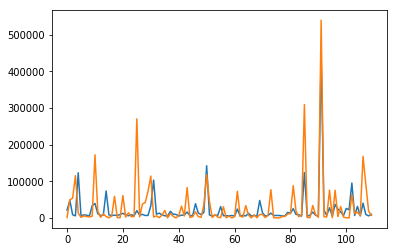

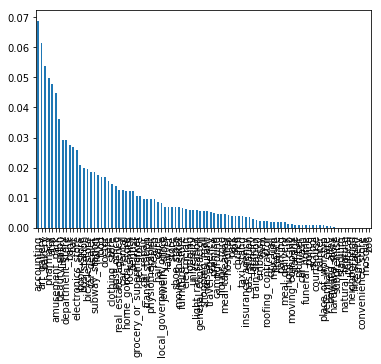

accounting           0.068848
art_gallery          0.061518
bakery               0.053665
pharmacy             0.049738
atm                  0.047644
amusement_park       0.044764
beauty_salon         0.036126
library              0.029058
department_store     0.029058
bank                 0.027487
bar                  0.026702
electronics_store    0.025916
book_store           0.020942
bus_station          0.019895
bicycle_store        0.019634
car_dealer           0.018586
subway_station       0.018586
florist              0.017539
food                 0.017016
doctor               0.016754
dtype: float32


In [60]:
clf_bow = train_printinfo(bow_types, targets.total[0])

lets try by total norm

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   42.8s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.7min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1337, silent=True, subsample=0.7)
mae 45.5302320482
clf score -0.17373841088


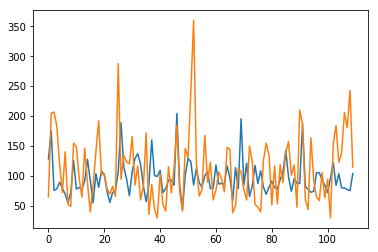

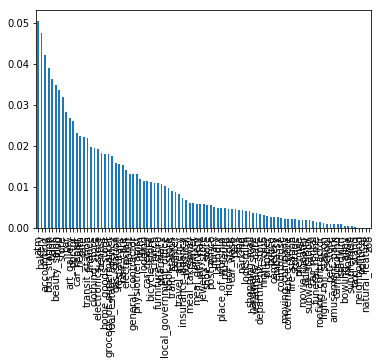

atm                  0.050463
bakery               0.047585
accounting           0.042098
bus_station          0.039039
bank                 0.036161
beauty_salon         0.034902
food                 0.033552
store                0.031933
bar                  0.028335
art_gallery          0.026716
doctor               0.025996
car_repair           0.023118
health               0.022308
cafe                 0.022038
transit_station      0.021948
finance              0.019610
clothing_store       0.019520
electronics_store    0.019160
dentist              0.018170
home_goods_store     0.018080
dtype: float32


In [61]:
clf_bownorm = train_printinfo(bow_types, targets.total_norm[1])

Lets see how the number of ameneties feature work

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done 330 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.3min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)
mae 25284.0909246
clf score 0.523461807511


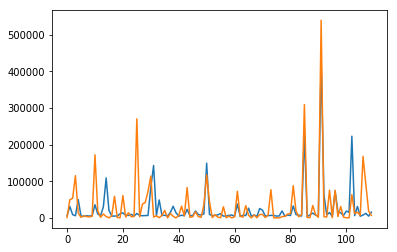

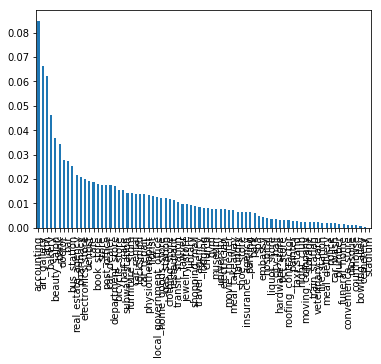

accounting            0.084856
art_gallery           0.066435
atm                   0.062056
bakery                0.046052
beauty_salon          0.036992
bank                  0.034425
doctor                0.027631
bar                   0.027178
bus_station           0.025366
real_estate_agency    0.021742
pharmacy              0.020685
electronics_store     0.019931
dentist               0.019327
cafe                  0.018723
book_store            0.018119
store                 0.017515
post_office           0.017364
car_dealer            0.017364
department_store      0.017062
bicycle_store         0.015401
dtype: float32
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   34.8s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.5min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)
mae 45.6731916563
clf score -0.170345430503


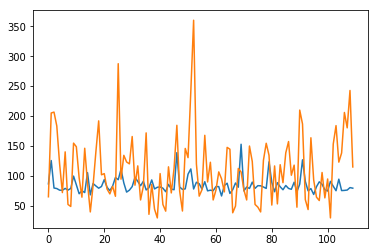

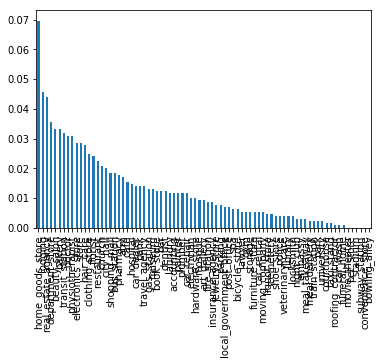

home_goods_store      0.069606
lodging               0.045630
real_estate_agency    0.044084
department_store      0.035576
beauty_salon          0.033256
bakery                0.033256
transit_station       0.031709
doctor                0.030936
physiotherapist       0.030936
electronics_store     0.028616
store                 0.028616
hair_care             0.027842
clothing_store        0.024749
florist               0.023975
restaurant            0.022428
church                0.020882
city_hall             0.020108
shopping_mall         0.018561
bus_station           0.018561
pharmacy              0.017788
dtype: float32


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)

In [62]:
train_printinfo(number_ameneties, targets.total[0])
train_printinfo(number_ameneties, targets.total_norm[1])

conclu

Now lets try position feature

In [63]:
feature_lat_lon = pd.concat({'latitude': mean_lat, 'longitude': mean_lon}, 1)
feature_lat_lon.head()

latitude  longitude
0  46.195629   6.193847
1  46.204399   6.200112
2  46.780945   6.636348
3  46.540162   6.621443
4  46.770865   6.650237

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done 340 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:   12.1s finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.6)
mae 19962.1475009
clf score 0.674500739499


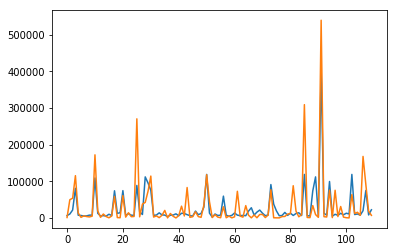

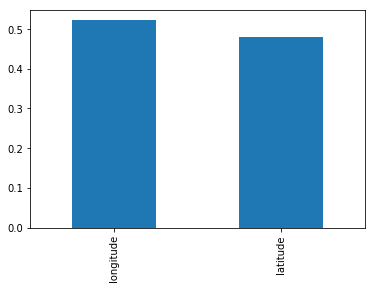

longitude    0.521395
latitude     0.478605
dtype: float32
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done 340 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:   10.8s finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1337, silent=True, subsample=0.8)
mae 43.0795689931
clf score -0.033906775455


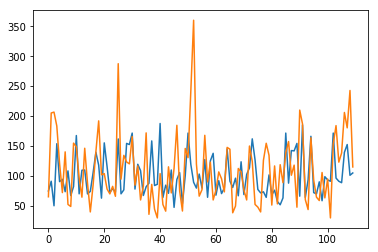

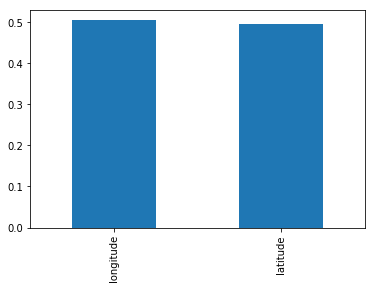

longitude    0.503962
latitude     0.496038
dtype: float32


In [64]:
clf_lat_lon_total = train_printinfo(feature_lat_lon, targets.total[0])
clf_lat_lon_totalnorm = train_printinfo(feature_lat_lon, targets.total_norm[1])

In [65]:
min_lat.min()
max_lat.max()
min_lon.min()
max_lon.max()

x = np.linspace(min_lat.min(), max_lat.max(), 1000)
y = np.linspace(min_lon.min(), max_lon.max(), 1000)

xx, yy = np.meshgrid(x,y)

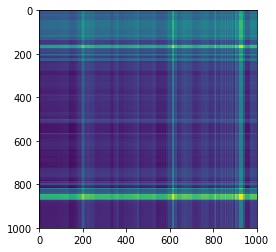

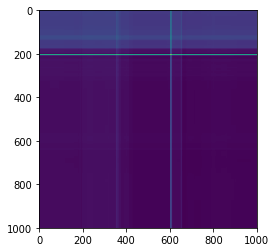

In [66]:
Z = clf_lat_lon_totalnorm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z)
plt.show()

Z = clf_lat_lon_total.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z)
plt.show()

cant really see, lets do something a bit smarter

In [67]:
ll = np.stack([mean_lat, mean_lon], 1)
dd = np.stack([dlat, dlon], 1) * 5
gen_point = lambda: np.random.normal(loc=ll, scale=dd)
sampled = np.concatenate([gen_point() for i in range(4)])
sampled = pd.DataFrame(sampled).dropna().as_matrix()

In [68]:
plt_map(sampled[:,0], sampled[:,1], [1]*len(sampled), clf_lat_lon_total.predict(sampled))

In [69]:
plt_map(sampled[:,0], sampled[:,1], [1]*len(sampled), clf_lat_lon_totalnorm.predict(sampled))

In [70]:
# lets use lat, lon and types
feature_bow_lat_lon = pd.concat([bow_types, feature_lat_lon], 1)
feature_bow_lat_lon.head()

accounting  amusement_park  art_gallery  atm  bakery  bank  bar  \
0           3               0            1    2       8     4    2   
1           0               0            0    0       2     0    0   
2           2               0            0    4       8     2    6   
3           0               0            0    0       0     0    3   
4           0               0            0    0       0     0    0   

   beauty_salon  bicycle_store  book_store    ...      subway_station  \
0             6              2           0    ...                   0   
1             0              0           0    ...                   0   
2             7              2           2    ...                   0   
3             4              0           0    ...                   0   
4             0              0           0    ...                   0   

   taxi_stand  train_station  transit_station  travel_agency  university  \
0           0              0                4              1           0   
1           0              0                2              0           0   
2           0              0                8              2           0   
3           0              0                2              0           0   
4           0              0                8              0           0   

   veterinary_care  zoo   latitude  longitude  
0                1    0  46.195629   6.193847  
1                0    0  46.204399   6.200112  
2                0    0  46.780945   6.636348  
3                0    0  46.540162   6.621443  
4                0    0  46.770865   6.650237  

[5 rows x 97 columns]

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   50.9s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  2.0min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.8)
mae 17968.0430487
clf score 0.752242664365


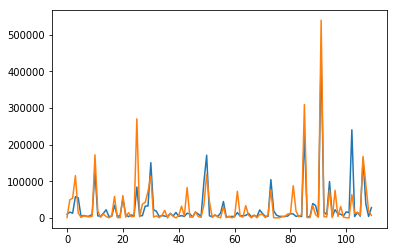

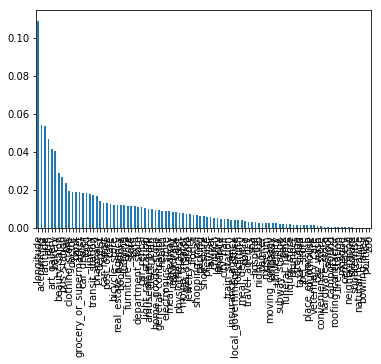

longitude                 0.109034
accounting                0.054128
latitude                  0.053349
atm                       0.046924
art_gallery               0.041667
bakery                    0.040304
beauty_salon              0.028816
bus_station               0.026869
bar                       0.023559
clothing_store            0.019470
doctor                    0.018886
bank                      0.018886
grocery_or_supermarket    0.018692
car_dealer                0.018497
food                      0.018302
library                   0.017913
transit_station           0.017329
pharmacy                  0.016550
dentist                   0.014019
car_repair                0.013240
dtype: float32
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   50.0s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.9min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.6)
mae 40.7945050568
clf score -0.0409179759374


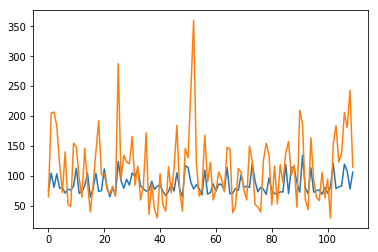

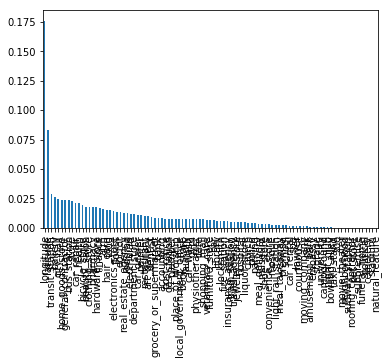

longitude             0.175962
latitude              0.083268
transit_station       0.029065
bakery                0.025923
city_hall             0.024352
home_goods_store      0.023566
general_contractor    0.023566
bus_station           0.023566
store                 0.022781
car_repair            0.021210
health                0.021210
bicycle_store         0.019639
beauty_salon          0.018068
clothing_store        0.018068
pharmacy              0.018068
hardware_store        0.017282
finance               0.016496
atm                   0.015711
hair_care             0.014925
food                  0.014925
dtype: float32


In [71]:
clf_best = train_printinfo(feature_bow_lat_lon, targets.total[0])
clf_bestnorm = train_printinfo(feature_bow_lat_lon, targets.total_norm[1])

we can see improvment

In [72]:
from sklearn import svm
# from sklearn.ensemble import RandomForestRegressor

tuned_parameters = [
                    {'kernel': ['rbf'], 'gamma': [14, 10, 8],
                     'C': [150, 200, 250]},
                    {'kernel': ['linear'], 'C': [5, 7, 10]}
                   ]
clf_svm = GridSearchCV(svm.SVR(), tuned_parameters, n_jobs=2, 
                   cv=KFold(n_splits=5, shuffle=True),
#                    scoring='accuracy',
                   verbose=1,
                   refit=True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.4min finished


Best estimator found by grid search:
SVR(C=150, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=14,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
mae 0.379235383228
clf score 0.4887732141


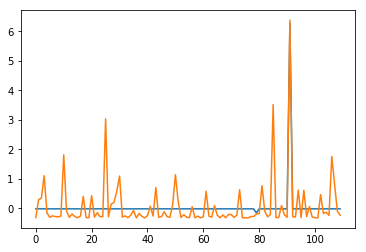

SVR(C=150, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=14,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [73]:
# this kind of model need to normalize the input to be able to train fast
# f = feature_bow_lat_lon.fillna(0)
# f = f - f.min()
# f = f / f.max()
# train_printinfo(f, targets.total_norm[1], clf=clf_svm)
feature_bow_lat_lon.longitude = feature_bow_lat_lon.longitude.fillna(feature_bow_lat_lon.longitude.mean())
feature_bow_lat_lon.latitude = feature_bow_lat_lon.latitude.fillna(feature_bow_lat_lon.latitude.mean())
f = feature_bow_lat_lon
f = f - f.mean()
f = f / f.std()
t = targets.total[0]
t = t - t.mean()
t = t / t.std()
t_norm = targets.total_norm[1]
t_norm = t_norm - t_norm.mean()
t_norm = t_norm / t_norm.std()
train_printinfo(f, t, clf=clf_svm)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   49.9s finished


Best estimator found by grid search:
SVR(C=150, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=8,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
mae 0.751884156695
clf score -0.023931991765


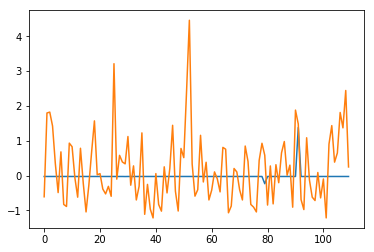

SVR(C=150, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=8,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [74]:
train_printinfo(f, t_norm, clf=clf_svm)

not very promising with svm
lets see what nn can do

In [75]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [76]:
def base():
    model = Sequential()
    model.add(Dense(60, input_dim=f.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(60, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(60, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=base, nb_epoch=100, batch_size=15, verbose=0)

mae 0.316716125675
clf score 0.340379787948


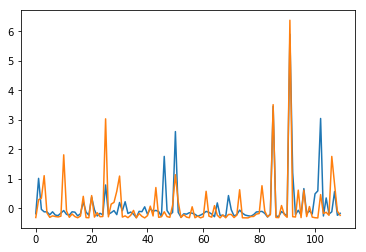

mae 0.852976421712
clf score 1.27871713042


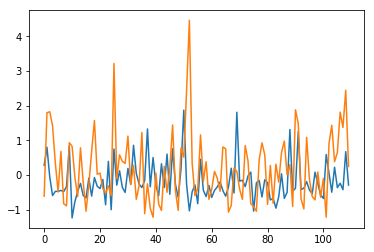

In [77]:
train_nogrid(f, t, clf=estimator)
train_nogrid(f, t_norm, clf=estimator)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   45.5s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.9min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.8)
mae 0.274191956286
clf score 0.752950147466


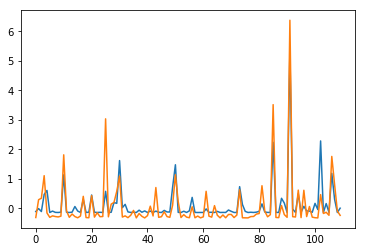

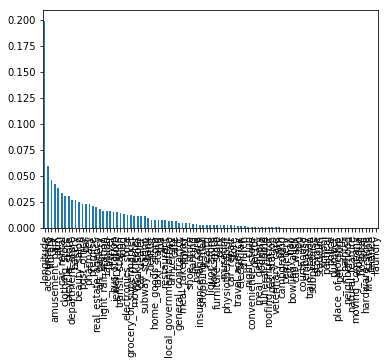

longitude             0.199370
accounting            0.059102
library               0.045705
amusement_park        0.042553
atm                   0.038613
car_rental            0.033097
clothing_store        0.030733
bicycle_store         0.030733
department_store      0.026793
bakery                0.026793
beauty_salon          0.025217
post_office           0.022853
bar                   0.022853
pharmacy              0.022853
premise               0.021277
real_estate_agency    0.019701
art_gallery           0.018125
light_rail_station    0.016548
latitude              0.016548
lawyer                0.016548
dtype: float32
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   52.8s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  2.2min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)
mae 0.682588380358
clf score 0.109733715041


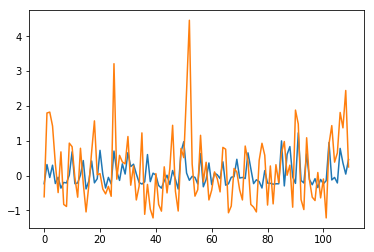

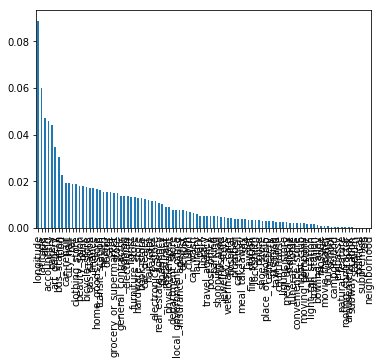

longitude           0.088848
latitude            0.059963
atm                 0.046984
accounting          0.045704
bakery              0.044059
art_gallery         0.034552
bus_station         0.030347
food                0.022486
car_repair          0.019378
city_hall           0.019013
bar                 0.018830
clothing_store      0.018647
beauty_salon        0.018099
bank                0.017916
bicycle_store       0.017550
gas_station         0.017002
finance             0.017002
home_goods_store    0.016819
transit_station     0.016088
health              0.015356
dtype: float32


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)

In [78]:
train_printinfo(f, t)
train_printinfo(f, t_norm)

simple NN do much better, but not as well as xgboost

In [79]:
X_train = f.iloc[X_train_id].as_matrix()
y_train = t_norm.iloc[y_train_id].as_matrix()
X_test = f.iloc[X_test_id].as_matrix()
y_test = t_norm.iloc[y_test_id].as_matrix()

model = base()
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=100, verbose=0)

0.987122485906


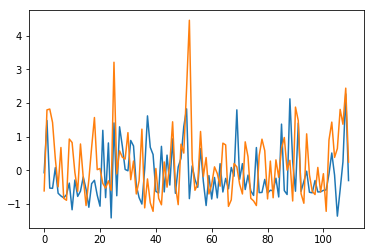

In [80]:
print(np.mean(np.abs(model.predict(X_test) - y_test)))

plt.plot(model.predict(X_test))
plt.plot(y_test)

As it is in most case with small dataset boosting algo perform way better, lets stop here for testing models

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   51.7s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  2.2min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.6)
mae 40.8361949809
clf score -0.0121470104553


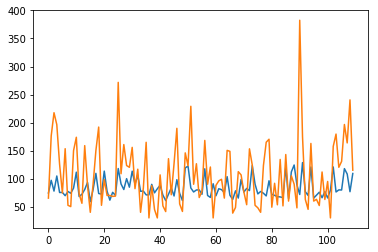

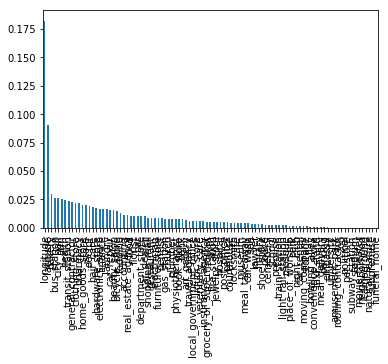

longitude             0.182243
latitude              0.090343
bakery                0.029595
bus_station           0.026480
city_hall             0.026480
atm                   0.024922
health                0.024143
transit_station       0.023364
general_contractor    0.022586
clothing_store        0.021807
pharmacy              0.021807
home_goods_store      0.020249
store                 0.020249
doctor                0.019470
hair_care             0.017913
hardware_store        0.017134
electronics_store     0.016355
finance               0.016355
laundry               0.016355
car_repair            0.015576
dtype: float32


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.6)

In [81]:
train_printinfo(feature_bow_lat_lon, targets.total_year_norm[2017])

cluster area

In [82]:
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn import mixture

In [83]:
# db = DBSCAN(eps=0.04, min_samples=4)
# db = KMeans(n_clusters=25)
# db = mixture.GaussianMixture(n_components=40)

In [84]:
# c = db.fit(np.stack([mean_lat.dropna(), mean_lon.dropna()], 1))
# pred = c.predict(np.stack([mean_lat.dropna(), mean_lon.dropna()], 1))
# pred = c.labels_

In [85]:
# plt.scatter(mean_lat.dropna(), mean_lon.dropna(), c=pred)

In [86]:
# plt_map(mean_lat.dropna(), mean_lon.dropna(), [0.001]*len(pred), [0.001]*len(pred), pred)

lets see what in our best model permit to improve the sales

In [87]:
d = pd.DataFrame()
for i, key in enumerate(bow_types.columns):
#     print(key)
    feature = bow_types[key]
    x = np.linspace(feature.min(), feature.max(), 10)
    x_to = np.zeros([10, bow_types.shape[1]])
    x_to[:, i] = x
    d[key] = clf_bow.predict(x_to)
#     plt.plot(clf_bow.predict(x_to))
#     plt.show()
# d.iloc[0].max()

assert np.all(d.max().index == bow_types.columns)
pd.DataFrame({"importance": clf_bow.feature_importances_, "output": d.max()}).sort_values('importance')[::-1]

importance         output
accounting                0.068848    6780.270996
art_gallery               0.061518    8452.603516
bakery                    0.053665   16025.885742
pharmacy                  0.049738   58649.328125
atm                       0.047644    6912.696777
amusement_park            0.044764  170788.718750
beauty_salon              0.036126    8845.867188
library                   0.029058   55138.332031
department_store          0.029058  108822.554688
bank                      0.027487    6818.595215
bar                       0.026702    9444.345703
electronics_store         0.025916    6780.270996
book_store                0.020942    6780.270996
bus_station               0.019895   11434.163086
bicycle_store             0.019634   24771.017578
car_dealer                0.018586   10568.208984
subway_station            0.018586   71306.429688
florist                   0.017539    7195.451660
food                      0.017016    8235.770508
doctor                    0.016754    6884.995605
cafe                      0.015445   12235.115234
clothing_store            0.014660    9325.350586
post_office               0.013874   46016.429688
real_estate_agency        0.012565   36524.214844
car_rental                0.012565   47760.035156
home_goods_store          0.012304    6780.270996
locksmith                 0.012304   13356.907227
dentist                   0.012304   14833.218750
grocery_or_supermarket    0.010733    6780.270996
pet_store                 0.010471    6949.729980
...                            ...            ...
roofing_contractor        0.002356    8053.242188
city_hall                 0.002094    6780.270996
museum                    0.002094    6780.270996
finance                   0.001832    6906.675293
parking                   0.001832    6837.087402
meal_delivery             0.001832    6780.270996
night_club                0.001309    7225.190430
moving_company            0.001309    6780.270996
storage                   0.001047    6780.270996
plumber                   0.001047    6780.270996
car_wash                  0.001047    6780.270996
funeral_home              0.001047    6780.270996
police                    0.001047    6780.270996
school                    0.000785    6780.270996
courthouse                0.000785    6780.270996
painter                   0.000785    6780.270996
place_of_worship          0.000785    6780.270996
veterinary_care           0.000524    6780.270996
bowling_alley             0.000524    6780.270996
hardware_store            0.000262    6780.270996
subpremise                0.000000    6780.270996
stadium                   0.000000    6780.270996
natural_feature           0.000000    6780.270996
political                 0.000000    6780.270996
neighborhood              0.000000    6780.270996
fire_station              0.000000    6780.270996
cemetery                  0.000000    6780.270996
convenience_store         0.000000    6780.270996
mosque                    0.000000    6780.270996
zoo                       0.000000    6780.270996

[95 rows x 2 columns]

In [88]:
d = pd.DataFrame()
for i, key in enumerate(bow_types.columns):
#     print(key)
    feature = bow_types[key]
    x = np.linspace(feature.min(), feature.max(), 10)
    x_to = np.zeros([10, bow_types.shape[1]])
    x_to[:, i] = x
    d[key] = clf_bownorm.predict(x_to)
#     plt.show()

assert np.all(d.max().index == bow_types.columns)
pd.DataFrame({"importance": clf_bownorm.feature_importances_, "output": d.max()}).sort_values('importance')[::-1]

importance      output
atm                       0.050463   92.769409
bakery                    0.047585  101.832924
accounting                0.042098   93.488754
bus_station               0.039039  102.694649
bank                      0.036161   92.769409
beauty_salon              0.034902   96.166748
food                      0.033552   92.769409
store                     0.031933   92.769409
bar                       0.028335   94.888611
art_gallery               0.026716   93.085129
doctor                    0.025996   92.769409
car_repair                0.023118  104.030548
health                    0.022308   92.769409
cafe                      0.022038   96.645233
transit_station           0.021948  101.381615
finance                   0.019610   92.769409
clothing_store            0.019520  103.751038
electronics_store         0.019160   92.769409
dentist                   0.018170   95.802834
home_goods_store          0.018080   99.226181
grocery_or_supermarket    0.017990   95.033218
real_estate_agency        0.017451   92.769409
gas_station               0.015832   95.948006
restaurant                0.015472   92.769409
hair_care                 0.015202   92.769409
electrician               0.014033   94.537247
florist                   0.013223  114.768723
general_contractor        0.013223   93.408386
physiotherapist           0.013133   95.063400
gym                       0.011784   99.265091
...                            ...         ...
plumber                   0.002968   92.769409
police                    0.002699   94.741501
cemetery                  0.002609   92.769409
embassy                   0.002519   92.769409
courthouse                0.002339   92.769409
moving_company            0.002249   92.769409
convenience_store         0.002159   92.769409
fire_station              0.002069   92.769409
storage                   0.002069   92.769409
premise                   0.001979   93.280319
movie_theater             0.001979   92.769409
university                0.001889   92.769409
subway_station            0.001799   92.769409
car_rental                0.001709   94.154388
funeral_home              0.001439   92.769409
roofing_contractor        0.001349   92.769409
light_rail_station        0.001079   92.769409
school                    0.000989   92.769409
pet_store                 0.000989   92.769409
amusement_park            0.000900   92.769409
campground                0.000810   95.238922
stadium                   0.000810   92.769409
bowling_alley             0.000540   92.769409
mosque                    0.000450   92.769409
subpremise                0.000360   92.769409
taxi_stand                0.000270   92.769409
neighborhood              0.000000   92.769409
political                 0.000000   92.769409
natural_feature           0.000000   92.769409
zoo                       0.000000   92.769409

[95 rows x 2 columns]

In [89]:
d = pd.DataFrame()
for i, key in enumerate(feature_bow_lat_lon.columns):
#     print(key)
    feature = feature_bow_lat_lon[key]
    x = np.linspace(feature.min(), feature.max(), 10)
    x_to = np.zeros([10, feature_bow_lat_lon.shape[1]])
    x_to[:, i] = x
    d[key] = clf_best.predict(x_to)
#     plt.plot(clf_bow.predict(x_to))
#     plt.show()
# d.iloc[0].max()

assert np.all(d.max().index == feature_bow_lat_lon.columns)
pd.DataFrame({"importance": clf_best.feature_importances_, "output": d.max()}).sort_values('importance')[::-1]

importance        output
longitude                 0.109034  18566.931641
accounting                0.054128  25411.775391
latitude                  0.053349  63265.691406
atm                       0.046924  21717.443359
art_gallery               0.041667  18042.517578
bakery                    0.040304  21088.058594
beauty_salon              0.028816  18508.226562
bus_station               0.026869  22789.458984
bar                       0.023559  19202.212891
clothing_store            0.019470  31539.033203
doctor                    0.018886  18288.931641
bank                      0.018886  18345.687500
grocery_or_supermarket    0.018692  32146.728516
car_dealer                0.018497  23842.015625
food                      0.018302  19041.941406
library                   0.017913  55524.777344
transit_station           0.017329  42466.093750
pharmacy                  0.016550  27866.699219
dentist                   0.014019  25229.597656
car_repair                0.013240  16981.019531
post_office               0.013045  29878.361328
cafe                      0.012656  18876.083984
bicycle_store             0.012072  62590.914062
real_estate_agency        0.012072  17693.656250
book_store                0.012072  19104.974609
lodging                   0.011877  17139.164062
furniture_store           0.011682  19856.810547
store                     0.011293  18426.537109
gym                       0.011293  16779.808594
department_store          0.011098  57708.652344
...                            ...           ...
moving_company            0.002531  16779.808594
embassy                   0.002531  17326.480469
university                0.002531  28936.300781
subway_station            0.002142  28300.019531
park                      0.002142  16779.808594
funeral_home              0.001947  16918.263672
liquor_store              0.001947  16779.808594
plumber                   0.001558  16779.808594
storage                   0.001558  16779.808594
taxi_stand                0.001558  16779.808594
pet_store                 0.001558  18708.410156
place_of_worship          0.001558  17464.556641
courthouse                0.001363  16779.808594
veterinary_care           0.001363  16779.808594
car_wash                  0.001168  16779.808594
convenience_store         0.000779  16779.808594
hardware_store            0.000584  16779.808594
school                    0.000584  16779.808594
campground                0.000389  16779.808594
roofing_contractor        0.000389  16779.808594
fire_station              0.000195  16779.808594
mosque                    0.000195  16779.808594
cemetery                  0.000195  16779.808594
neighborhood              0.000195  16779.808594
stadium                   0.000195  16779.808594
subpremise                0.000000  16779.808594
natural_feature           0.000000  16779.808594
bowling_alley             0.000000  16779.808594
political                 0.000000  16779.808594
zoo                       0.000000  16779.808594

[97 rows x 2 columns]

In [90]:
d = pd.DataFrame()
for i, key in enumerate(feature_bow_lat_lon.columns):
#     print(key)
    feature = feature_bow_lat_lon[key]
    x = np.linspace(feature.min(), feature.max(), 10)
    x_to = np.zeros([10, feature_bow_lat_lon.shape[1]])
    x_to[:, i] = x
    d[key] = clf_bestnorm.predict(x_to)
#     plt.plot(clf_bow.predict(x_to))
#     plt.show()
# d.iloc[0].max()

assert np.all(d.max().index == feature_bow_lat_lon.columns)
pd.DataFrame({"importance": clf_bestnorm.feature_importances_, "output": d.max()}).sort_values('importance')[::-1]

importance     output
longitude             0.175962  79.940994
latitude              0.083268  91.602509
transit_station       0.029065  82.275314
bakery                0.025923  82.187408
city_hall             0.024352  93.797081
home_goods_store      0.023566  87.691368
general_contractor    0.023566  80.853111
bus_station           0.023566  83.181023
store                 0.022781  87.658447
car_repair            0.021210  80.047913
health                0.021210  81.589073
bicycle_store         0.019639  92.114220
beauty_salon          0.018068  79.940994
clothing_store        0.018068  89.390549
pharmacy              0.018068  87.307434
hardware_store        0.017282  83.382591
finance               0.016496  85.655663
atm                   0.015711  80.138947
hair_care             0.014925  81.678642
food                  0.014925  82.163116
electronics_store     0.014140  83.274208
florist               0.013354  80.055328
doctor                0.013354  82.130867
real_estate_agency    0.012569  80.901352
lodging               0.012569  79.940994
electrician           0.011783  80.165970
department_store      0.011783  88.423744
car_dealer            0.010998  83.668129
painter               0.010998  81.216988
restaurant            0.010212  80.304985
...                        ...        ...
light_rail_station    0.002357  79.940994
meal_takeaway         0.002357  79.940994
premise               0.002357  79.940994
school                0.002357  79.940994
car_rental            0.001571  79.940994
spa                   0.001571  80.265152
lawyer                0.001571  80.455368
courthouse            0.001571  79.940994
moving_company        0.001571  79.940994
park                  0.001571  79.940994
amusement_park        0.000786  79.940994
embassy               0.000786  79.940994
storage               0.000786  79.940994
university            0.000786  79.940994
campground            0.000786  80.413437
night_club            0.000786  79.940994
bowling_alley         0.000786  79.940994
taxi_stand            0.000000  79.940994
zoo                   0.000000  79.940994
movie_theater         0.000000  79.940994
neighborhood          0.000000  79.940994
subway_station        0.000000  79.940994
roofing_contractor    0.000000  79.940994
pet_store             0.000000  79.940994
subpremise            0.000000  79.940994
funeral_home          0.000000  79.940994
political             0.000000  79.940994
cemetery              0.000000  79.940994
stadium               0.000000  79.940994
natural_feature       0.000000  79.940994

[97 rows x 2 columns]